In [ ]:
import os
import tarfile
import urllib.request
import numpy as np
from PIL import Image
from scipy.io import loadmat
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision
from torch.cuda.amp import GradScaler, autocast

In [ ]:
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"{filename} downloaded.")
    else:
        print(f"{filename} already exists.")

# URLs for dataset and labels
DATASET_URL = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
LABELS_URL = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
SETID_URL = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat"

# File paths
DOWNLOAD_PATH = "./102flowers.tgz"
DATASET_DIR = "./102flowers"
LABELS_PATH = os.path.join(DATASET_DIR, "imagelabels.mat")
SETID_PATH = os.path.join(DATASET_DIR, "setid.mat")

# Create the dataset directory if it doesn't exist
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)

# Download files if not present
download_file(DATASET_URL, DOWNLOAD_PATH)
download_file(LABELS_URL, LABELS_PATH)
download_file(SETID_URL, SETID_PATH)

# Extract dataset
if not os.path.exists(os.path.join(DATASET_DIR, "jpg")):
    print("Extracting dataset...")
    with tarfile.open(DOWNLOAD_PATH, "r:gz") as tar:
        tar.extractall(path=DATASET_DIR)
    print("Extraction complete.")

./102flowers.tgz already exists.
./102flowers/imagelabels.mat downloaded.
./102flowers/setid.mat downloaded.
Extracting dataset...
Extraction complete.


In [ ]:
def download_extract(url,download_path,extract_path):
    if not os.path.isdir(download_path):
        print("Downloading dataset")
        urllib.request.urlretrieve(url,download_path)
        print("Downloading Finished")

    if not os.path.exists(extract_path):
      print("Extracting dataset")
      with tarfile.open(download_path,'r:gz') as tar:
        tar.extractall(extract_path)
      print("Extracting Finished")
    else:
      print("Dataset already exists")

    return None

DATASET_URL = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
DATASET_DIR = "./102flowers"
DOWNLOAD_PATH = "./102flowers.tgz"

download_extract(DATASET_URL,DOWNLOAD_PATH,DATASET_DIR)


Dataset already exists


In [ ]:

class FlowersDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = os.path.join(root_dir,"jpg") # The images are stored in the "jpg" subdirectory
        self.image_paths = sorted([os.path.join(self.root_dir, img) for img in os.listdir(self.root_dir) if img.endswith('.jpg')])
        self.transform = transform

        # Load the labels from the mat file
        labels_file = os.path.join(root_dir, 'imagelabels.mat') # Correct path to labels file.
        labels_mat = scipy.io.loadmat(labels_file)
        self.labels = labels_mat['labels'][0]

        # Create a mapping of image names to labels
        self.image_name_to_label = {}
        for i, image_path in enumerate(self.image_paths):
            image_name = os.path.basename(image_path)
            self.image_name_to_label[image_name] = self.labels[i] - 1 # Subtract 1 to get 0-indexed labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image_name = os.path.basename(img_path) # Get the image name
        label = self.image_name_to_label[image_name] # Use image name to look up the label

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=  [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

flowers_dataset = FlowersDataset(root_dir=DATASET_DIR, transform=transform)

dataloader = DataLoader(flowers_dataset,batch_size=32,shuffle=True)


In [ ]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

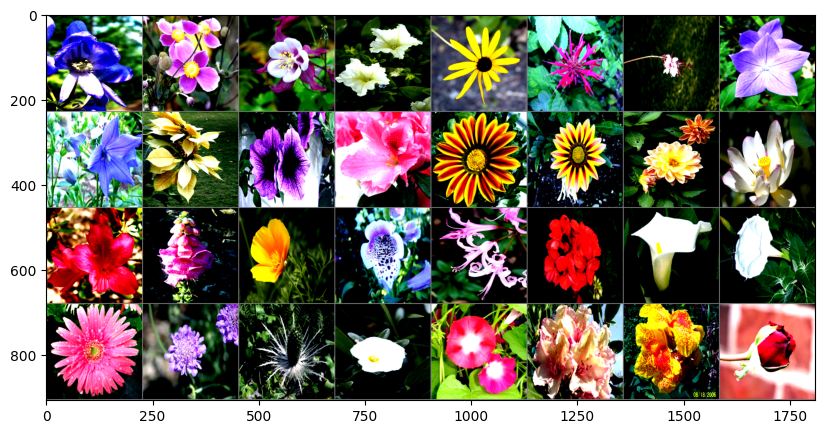

Labels: tensor([ 8, 61, 83, 50, 62, 91, 56, 18, 18, 43, 50, 71, 70, 70, 59, 77, 71, 93,
        64, 93, 36, 57, 19, 74, 40, 21, 34, 63, 75, 71, 89, 73])


In [ ]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print("Labels:", labels)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(pretrained = True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 102)

resnet50 = resnet50.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)

In [ ]:
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 102)

resnet50 = resnet50.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)


In [ ]:
scaler = GradScaler()

<ipython-input-19-9f6a838c5572>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():  # Mixed Precision
            outputs = resnet50(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training Complete!")

<ipython-input-20-963df092ff91>:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


Epoch [1/5], Loss: 1.5232
Epoch [2/5], Loss: 0.1439
Epoch [3/5], Loss: 0.0532
Epoch [4/5], Loss: 0.0356
Epoch [5/5], Loss: 0.0544
Training Complete!


In [ ]:
def imshow(img,title):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(10,5))
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.title(title)
  plt.show()

In [ ]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

In [ ]:
resnet50.eval()
with torch.no_grad():
    outputs = resnet50(images.to(device))
    _, predicted = torch.max(outputs, 1)

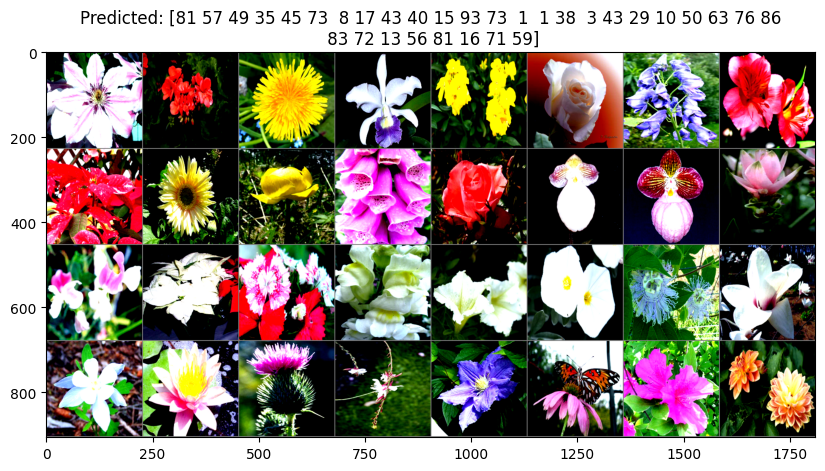

In [ ]:
imshow(torchvision.utils.make_grid(images), title=f"Predicted: {predicted.cpu().numpy()}")

In [ ]:
resnet50.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Overall Accuracy: {accuracy * 100:.2f}%")


✅ Overall Accuracy: 98.72%
